In [1]:
import numpy as np
import gym
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import time

In [2]:
class DQN_Leaner():
    
    def __init__(self, env, lr, gamma, epsilon, eps_decay):
        self.env=env
        self.lr=lr
        self.gamma=gamma
        self.epsilon=epsilon
        self.eps_decay=eps_decay
        self.rewards=[]
        
    def init_model(self, hidden_layers):
        lr=self.lr
        n_actions = self.env.action_space.n
        state_dim = len(self.env.reset())
        self.model = tf.keras.Sequential()
        for i in range(len(hidden_layers)):
            if i==0:
                self.model.add(Dense(hidden_layers[0], input_dim=state_dim, activation='relu'))
            else:
                self.model.add(Dense(hidden_layers[i], activation='relu'))
        self.model.add(Dense(n_actions,activation='linear'))
        self.model.compile(loss='mse',optimizer=Adam(learning_rate=lr))

    def train(self, n_eps, batch_size, verbose=False):
        n_actions = self.env.action_space.n
        state_dim = len(self.env.reset())

        eps=self.epsilon
        cache=None
        
        tic=time.time()

        for ep in range(n_eps):
            s = self.env.reset()
            finished = False

            total_reward=0

            while finished == False:
                if np.random.random() < eps:
                    a = np.random.randint(n_actions)
                else:
                    a = np.argmax(self.model.predict(s.reshape((1, state_dim))))
                s_, r, finished, _ = self.env.step(a)
                total_reward+=r
                obs=np.hstack((s,a,r,finished,s_)).reshape((1,state_dim*2+3))
                try:
                    cache=np.vstack((cache,obs))
                except:
                    cache=obs

                n=min(cache.shape[0],batch_size)
                
                if n<batch_size:
                    continue
                else:
                    rand=np.random.choice(cache.shape[0], n, replace=False)
                    sample=cache[rand,:]

                S=sample[:,:state_dim]
                A=sample[:,state_dim].astype('int')
                Y=self.model.predict(S)
                R=sample[:,state_dim+1]
                S_=sample[:,-state_dim:]
                Y[np.arange(n),A]=R+self.gamma*self.model.predict(S_).max(axis=1)*(sample[:,state_dim+2]==0)

                self.model.fit(S,Y,epochs=1, verbose=0, batch_size=n)

                s=s_
            eps*=self.eps_decay
            #env.close()
            self.rewards.append(total_reward)

            if verbose:
                if ep==0:
                    print("")
                    print("Training Start")
                elif ep%10==0:
                    print("Episode: {}".format(ep))
                    print("Training Reward: {}".format(total_reward))
                    print("Time Elapsed: {} secs".format(time.time()-tic))

In [3]:
def evaluate(env,model,n_eps):
    rewards=[]
    for ep in range(n_eps):
        s = env.reset()
        total_reward=0
        finished=False
        while finished==False:
            env.render()
            a = np.argmax(model.predict(s.reshape((1, len(s))))[0])
            s, r, finished, _ = env.step(a)
            total_reward+=r            
        rewards.append(total_reward)
    env.close()
    return rewards

In [ ]:
env = gym.make('LunarLander-v2')
# env = gym.make('CartPole-v1')
learner=DQN_Leaner(env=env, lr=0.0005, gamma=0.99, epsilon=1, eps_decay=0.995)
learner.init_model(hidden_layers=(32,64,16))
learner.train(500,64,verbose=1)

In [ ]:
learner.model.save("./models/model_1")

# Trained Agent

In [9]:
model=tf.keras.models.load_model("./models/model_1")
env = gym.make('LunarLander-v2')
env = gym.wrappers.Monitor(env, "./video", force=True)
s = env.reset()
finished=False
while finished==False:
    env.render()
    a = np.argmax(model.predict(s.reshape((1, len(s))))[0])
    s, r, finished, _ = env.step(a)
env.close()

import io
import base64
from IPython.display import HTML

video = io.open('./video/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))

In [38]:
rewards_trained=evaluate(env,model,100)

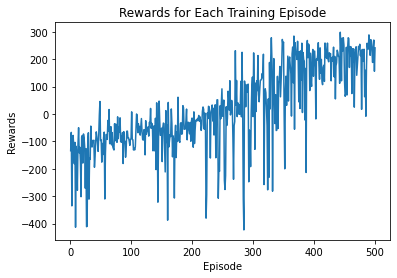

In [31]:
plt.clf()
plt.plot(np.arange(1,501), learner.rewards)
plt.title('Rewards for Each Training Episode')
plt.ylabel('Rewards')
plt.xlabel('Epsidoe')
plt.savefig('Rewards_Training.png')

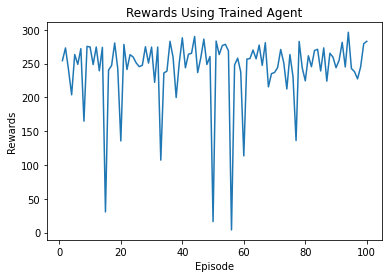

In [43]:
plt.clf()
plt.plot(np.arange(1,101), rewards_trained)
plt.title('Rewards Using Trained Agent')
plt.ylabel('Rewards')
plt.xlabel('Episode')
plt.savefig('Rewards_trained.png')

## Hyper-parameters

In [4]:
models={}
env = gym.make('LunarLander-v2')
epsilon=0.2
learner=DQN_Leaner(env=env, lr=0.0005, gamma=0.99, epsilon=epsilon, eps_decay=0.995)
learner.init_model(hidden_layers=(32,64,16))
learner.train(500,64,verbose=1)
key='epsilon_'+str(epsilon)
models[key]=learner    

gamma=0.6
learner=DQN_Leaner(env=env, lr=0.0005, gamma=gamma, epsilon=1, eps_decay=0.995)
learner.init_model(hidden_layers=(32,64,16))
learner.train(500,64,verbose=1)
key='gamma_'+str(gamma)
models[key]=learner    

lr=0.01
learner=DQN_Leaner(env=env, lr=lr, gamma=0.99, epsilon=1, eps_decay=0.995)
learner.init_model(hidden_layers=(32,64,16))
learner.train(500,64,verbose=1)
key='lr_'+str(lr)
models[key]=learner    


Training Start
Episode: 10
Training Reward: -346.39509531647457
Time Elapsed: 74.04467010498047 secs
Episode: 20
Training Reward: -223.64350834168317
Time Elapsed: 165.8102638721466 secs
Episode: 30
Training Reward: -123.21483106877022
Time Elapsed: 254.37668418884277 secs
Episode: 40
Training Reward: -102.80120640460706
Time Elapsed: 331.0812246799469 secs
Episode: 50
Training Reward: -54.825938358166574
Time Elapsed: 421.3099136352539 secs
Episode: 60
Training Reward: -259.4274652995048
Time Elapsed: 593.5041682720184 secs
Episode: 70
Training Reward: 140.2188467487843
Time Elapsed: 939.5847585201263 secs
Episode: 80
Training Reward: -246.7317536346353
Time Elapsed: 1738.7982835769653 secs
Episode: 90
Training Reward: -22.436284030560884
Time Elapsed: 2548.54332447052 secs
Episode: 100
Training Reward: -0.10693148299981647
Time Elapsed: 3417.388603925705 secs
Episode: 110
Training Reward: -3.123897207494333
Time Elapsed: 4320.910910606384 secs
Episode: 120
Training Reward: -93.12957

Episode: 470
Training Reward: -280.55301515004896
Time Elapsed: 9900.900582313538 secs
Episode: 480
Training Reward: -177.78339354300434
Time Elapsed: 10196.072841644287 secs
Episode: 490
Training Reward: 214.5135047820129
Time Elapsed: 10478.928602933884 secs

Training Start
Episode: 10
Training Reward: -134.13265035117274
Time Elapsed: 66.76425623893738 secs
Episode: 20
Training Reward: -76.58892172699754
Time Elapsed: 138.5756618976593 secs
Episode: 30
Training Reward: -43.46206452873204
Time Elapsed: 219.79337668418884 secs
Episode: 40
Training Reward: -112.1496498420093
Time Elapsed: 297.74395275115967 secs
Episode: 50
Training Reward: -285.9457303829815
Time Elapsed: 382.7541539669037 secs
Episode: 60
Training Reward: -158.23303273428084
Time Elapsed: 469.44229102134705 secs
Episode: 70
Training Reward: -514.2871006752198
Time Elapsed: 548.0701885223389 secs
Episode: 80
Training Reward: -240.08614951892667
Time Elapsed: 647.4529983997345 secs
Episode: 90
Training Reward: -498.571

In [5]:
epsilon=0.6
learner=DQN_Leaner(env=env, lr=0.0005, gamma=0.99, epsilon=epsilon, eps_decay=0.995)
learner.init_model(hidden_layers=(32,64,16))
learner.train(500,64,verbose=1)
key='epsilon_'+str(epsilon)
models[key]=learner    

gamma=0.9
learner=DQN_Leaner(env=env, lr=0.0005, gamma=gamma, epsilon=1, eps_decay=0.995)
learner.init_model(hidden_layers=(32,64,16))
learner.train(500,64,verbose=1)
key='gamma_'+str(gamma)
models[key]=learner    

lr=0.00001
learner=DQN_Leaner(env=env, lr=lr, gamma=0.99, epsilon=1, eps_decay=0.995)
learner.init_model(hidden_layers=(32,64,16))
learner.train(500,64,verbose=1)
key='lr_'+str(lr)
models[key]=learner   


Training Start
Episode: 10
Training Reward: -105.91815921316744
Time Elapsed: 81.11794352531433 secs
Episode: 20
Training Reward: -313.6672140371323
Time Elapsed: 176.69724822044373 secs
Episode: 30
Training Reward: -182.85292093183676
Time Elapsed: 315.7867634296417 secs
Episode: 40
Training Reward: -173.82369378272426
Time Elapsed: 424.80991768836975 secs
Episode: 50
Training Reward: 17.50327878202853
Time Elapsed: 576.0393438339233 secs
Episode: 60
Training Reward: -54.718955890241915
Time Elapsed: 866.1899073123932 secs
Episode: 70
Training Reward: -18.22848403217742
Time Elapsed: 1138.3339183330536 secs
Episode: 80
Training Reward: -129.27955025941066
Time Elapsed: 1666.496464252472 secs
Episode: 90
Training Reward: -102.6952371755657
Time Elapsed: 2106.090075969696 secs
Episode: 100
Training Reward: 61.038513699687016
Time Elapsed: 2641.091054201126 secs
Episode: 110
Training Reward: 99.55973194758154
Time Elapsed: 3360.315862417221 secs
Episode: 120
Training Reward: 61.42008914

Episode: 470
Training Reward: -247.80982431782678
Time Elapsed: 13378.358200788498 secs
Episode: 480
Training Reward: -194.29920766736754
Time Elapsed: 13803.550790309906 secs
Episode: 490
Training Reward: -57.37308732205981
Time Elapsed: 14205.557366371155 secs

Training Start
Episode: 10
Training Reward: -196.58910462624783
Time Elapsed: 70.91717600822449 secs
Episode: 20
Training Reward: -460.7328102169621
Time Elapsed: 136.12522888183594 secs
Episode: 30
Training Reward: -233.82624708650386
Time Elapsed: 203.88626646995544 secs
Episode: 40
Training Reward: -125.08051605049577
Time Elapsed: 270.9135694503784 secs
Episode: 50
Training Reward: -473.07755448762356
Time Elapsed: 342.512921333313 secs
Episode: 60
Training Reward: -289.4224440954365
Time Elapsed: 394.68776416778564 secs
Episode: 70
Training Reward: -304.1481130790038
Time Elapsed: 456.2111163139343 secs
Episode: 80
Training Reward: -371.40356684473187
Time Elapsed: 517.808144569397 secs
Episode: 90
Training Reward: -21.92

In [6]:
models

{'epsilon_0.2': <__main__.DQN_Leaner at 0x7f03aef91220>,
 'gamma_0.2': <__main__.DQN_Leaner at 0x7f03af2421f0>,
 'lr_0.01': <__main__.DQN_Leaner at 0x7f038c5b12b0>,
 'epsilon_0.6': <__main__.DQN_Leaner at 0x7f03af21dca0>,
 'gamma_0.6': <__main__.DQN_Leaner at 0x7effcb650580>,
 'lr_1e-05': <__main__.DQN_Leaner at 0x7effb3df4610>}

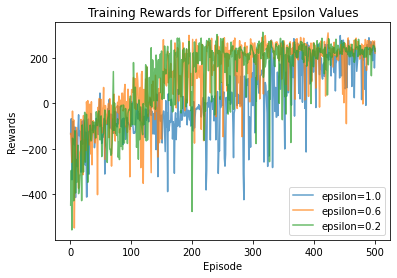

In [41]:
plt.clf()
plt.plot(np.arange(1,501), rewards, label='epsilon=1.0',alpha=0.7)
plt.plot(np.arange(1,501), models['epsilon_0.6'].rewards, label='epsilon=0.6',alpha=0.7)
plt.plot(np.arange(1,501), models['epsilon_0.2'].rewards, label='epsilon=0.2',alpha=0.7)
plt.title('Training Rewards for Different Epsilon Values')
plt.ylabel('Rewards')
plt.xlabel('Episode')
plt.legend()
plt.savefig('Rewards_Training_Epsilon.png')

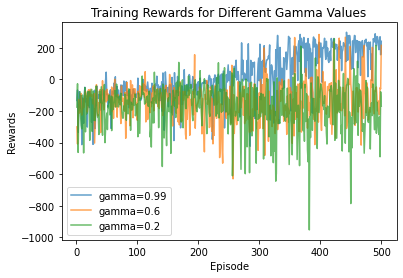

In [53]:
plt.clf()
plt.plot(np.arange(1,501), rewards, label='gamma=0.99',alpha=0.7)
plt.plot(np.arange(1,501), models['gamma_0.6'].rewards, label='gamma=0.6',alpha=0.7)
plt.plot(np.arange(1,501), models['gamma_0.2'].rewards, label='gamma=0.2',alpha=0.7)
plt.title('Training Rewards for Different Gamma Values')
plt.ylabel('Rewards')
plt.xlabel('Episode')
plt.legend()
plt.savefig('Rewards_Training_Gamma.png')

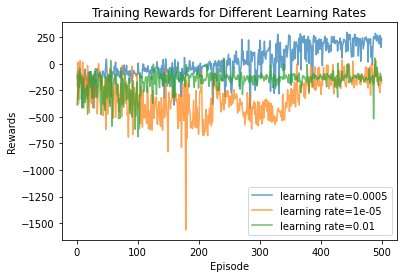

In [50]:
plt.clf()
plt.plot(np.arange(1,501), rewards, label='learning rate=0.0005',alpha=0.7)
plt.plot(np.arange(1,501), models['lr_1e-05'].rewards, label='learning rate=1e-05',alpha=0.7)
plt.plot(np.arange(1,501), models['lr_0.01'].rewards, label='learning rate=0.01',alpha=0.7)
plt.title('Training Rewards for Different Learning Rates')
plt.ylabel('Rewards')
plt.xlabel('Episode')
plt.legend()
plt.savefig('Rewards_Training_Learning_Rate.png')

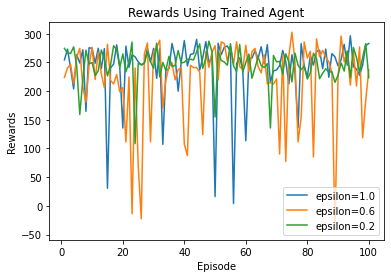

In [44]:
rewards_trained_eps6=evaluate(env,models['epsilon_0.6'].model,100)
rewards_trained_eps2=evaluate(env,models['epsilon_0.2'].model,100)
plt.clf()
plt.plot(np.arange(1,101), rewards_trained, label='epsilon=1.0')
plt.plot(np.arange(1,101), rewards_trained_eps6, label='epsilon=0.6')
plt.plot(np.arange(1,101), rewards_trained_eps2, label='epsilon=0.2')
plt.title('Rewards Using Trained Agent')
plt.ylabel('Rewards')
plt.xlabel('Episode')
plt.legend()
plt.savefig('Rewards_trained_epsilon.png')

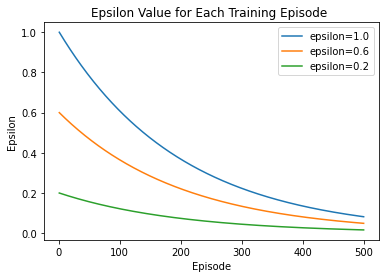

In [46]:
eps_10=[1*0.995**x for x in range(500)]
eps_6=[0.6*0.995**x for x in range(500)]
eps_2=[0.2*0.995**x for x in range(500)]
plt.clf()
plt.plot(np.arange(1,501), eps_10, label='epsilon=1.0')
plt.plot(np.arange(1,501), eps_6, label='epsilon=0.6')
plt.plot(np.arange(1,501), eps_2, label='epsilon=0.2')
plt.title('Epsilon Value for Each Training Episode ')
plt.ylabel('Epsilon')
plt.xlabel('Episode')
plt.legend()
plt.savefig('Epsilon_Decay.png')